# Convolutional Autoencoder (AE) and Spatial filters for DICOM x-ray image (with anti-scatter grid) denoising

## Set up environment

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 37.8 gigabytes of available RAM

You are using a high-RAM runtime!


## Import necessary libraries and packages

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from google.colab.patches import cv2_imshow
import skimage
from skimage import data
from skimage import util
from skimage.filters.rank import gradient
from skimage.color import rgb2gray
from skimage.morphology import disk
from scipy import ndimage, misc
import scipy.misc

from PIL import Image, ImageOps

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, UpSampling2D
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, Conv2D, Reshape, Conv2DTranspose
#from tensorflow.keras.layers import Dense, Input, Dropout
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import distribute

from sklearn.model_selection import train_test_split
from skimage import data
from skimage.filters.rank import gradient
from skimage.color import rgb2gray
from skimage.morphology import disk

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error, mean_squared_error, normalized_root_mse

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
#print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.8.2
Eager mode:  True
GPU is NOT AVAILABLE


## Install pydicom

In [5]:
!pip install pydicom
import pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.0 MB/s 


## Connect google colab with drive

In [6]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Reading in the DICOM images: Load the dataset

### Read low dose, high intensity image (0.25x clinical dose - noisiest)

In [7]:
#LOW DOSE IMAGE
imagepath = '/content/gdrive/My Drive/DICOM/WithGrid/0.25xClinDoseGrid/DICOM/0001001A' #0.2x clinical dose - noisiest

data = pydicom.dcmread(imagepath) 

print(data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 212
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Processing
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.51.0.7.2565165143.26579.37952.48631.61123.18220.20992
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.51.0.1.3
(0002, 0013) Implementation Version Name         SH: 'AGFA DTF1.0.95'
(0002, 0016) Source Application Entity Title     AE: 'AE_AGFA_NX'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'FLAT FIELD 200']
(0008, 0016) SOP Class UID                       UI: Digital X-Ray Image Storage - For Processing
(0008, 0018) SOP Instance UID                    UI: 1.3.51.0.7.2565165143.26579.37952.48631.61

### Display the low dose, 0.25 clinical dose, image with its dimensions

6631180 1603 0
----------0.25x clinicalGrid----------
| original image size: 6631180 |
| maximum: 1603 |
| minimum: 0 |
---------------------------------


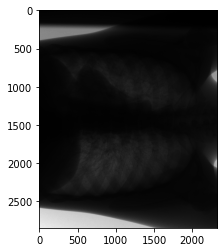

In [8]:
reference = data.pixel_array

#Print size
refsize = reference.size
refmax = np.max(reference)
refmin = np.min(reference)
print(refsize,refmax,refmin)  
 
#show the image
print('----------0.25x clinicalGrid----------')
print('| original image size: %d'%(refsize), '|')
print('| maximum: %d'%(refmax), '|')
print('| minimum: %d'%(refmin), '|')
print('---------------------------------')
plt.imshow(reference/refmax, cmap= 'gray')
plt.show()

### High dose, low intensity image (3.2x clinical dose - least noisy)

In [9]:
imagepath_hd = '/content/gdrive/My Drive/DICOM/WithGrid/3.2xClinDoseGrid/DICOM/0001001A' #3.2x clinical dose - least noisy

data_hd = pydicom.read_file(imagepath_hd)

print(data_hd)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 210
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Processing
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.51.0.7.1727395381.20536.52296.36107.27975.9847.5366
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.51.0.1.3
(0002, 0013) Implementation Version Name         SH: 'AGFA DTF1.0.95'
(0002, 0016) Source Application Entity Title     AE: 'AE_AGFA_NX'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'FLAT FIELD 200']
(0008, 0016) SOP Class UID                       UI: Digital X-Ray Image Storage - For Processing
(0008, 0018) SOP Instance UID                    UI: 1.3.51.0.7.1727395381.20536.52296.36107.2797

### Display the low dose, 3.2 clinical dose, image with its dimensions

6631180 22166 0
--------3.2x clinicalGrid------------
| original image size: 6631180 |
| maximum: 22166 |
| minimum: 0 |
---------------------------------


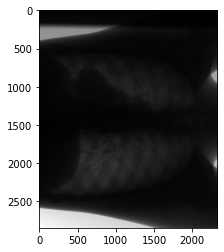

In [10]:
hd_reference = data_hd.pixel_array

#Print size
hdrefsize = hd_reference.size
hdrefmax = np.max(hd_reference)
hdrefmin = np.min(hd_reference)
print(hdrefsize, hdrefmax, hdrefmin)  

#show the image
print('--------3.2x clinicalGrid------------')
print('| original image size: %d'%(hdrefsize), '|')
print('| maximum: %d'%(hdrefmax), '|')
print('| minimum: %d'%(hdrefmin), '|')
print('---------------------------------')
plt.imshow(hd_reference/hdrefmax, cmap= 'gray')
plt.show()

## Rescale the two DICOM images by defining the 'slices' of the image into 1900x1900 dimesions for computational efficiency

### Rescale low-dose image (1st image)








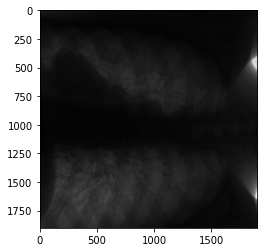

In [11]:
ref = reference[400:2300, 400:2300]
np.shape(ref)
plt.imshow(ref/np.max(ref), cmap= 'gray')
plt.show()

### Rescale high-dose image (2nd image)


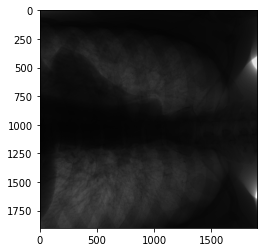

In [12]:
hd_ref = hd_reference[400:2300, 400:2300]
np.shape(hd_ref)
plt.imshow(hd_ref/np.max(hd_ref), cmap= 'gray')
plt.show()

### Display and find out the current size (dimensions) of the 1st image and 2nd image

current image size: 1900 x 1900


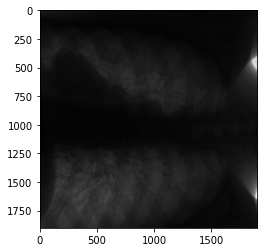

In [13]:
width, height = ref.shape  

print("current image size: %d x %d"%(width, height))

#show the image
plt.imshow(ref, cmap= 'gray')
plt.show()

current image size: 1900 x 1900


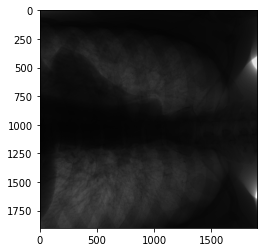

In [14]:
width, height = hd_ref.shape  

print("current image size: %d x %d"%(width, height))

#show the image
plt.imshow(hd_ref, cmap= 'gray')
plt.show()


### Convert the low and high doses images (ref and hd_ref) to a Numpy array

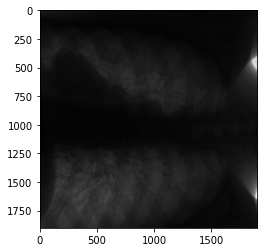

In [15]:
mywidth = 1900 #width
myheight = 1900 #height

#convert to an np array
ref = np.array(ref)

#print resulting image
plt.imshow(ref, cmap= 'gray')
plt.show()

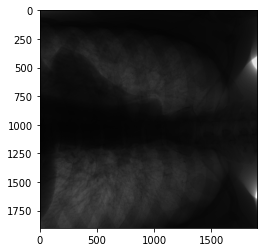

In [16]:
hd_ref = np.array(hd_ref)

#print resulting image
plt.imshow(hd_ref, cmap= 'gray')
plt.show()

### Add a channel index at the end of each np.array

In [17]:
myrefs = [ref]
myhd_refs = [hd_ref]

#add a channel index at the end of each np.array
channel1 = np.expand_dims(ref, 2)
channel2 = np.expand_dims(hd_ref, 2)

## Using Keras' image_data_generator to create a dataset


>  Define each high dose and low dose samples variable as single image and add a dimension for each

> Image data augmentation generator

> Create the new dataset from the original slices of the images

> Storage arrays

> Instanciating the generator

> Add the instances to the storage arrays

> Normalising the image dataset (high and low dose)

In [18]:
#using Keras' image_data_generator to create a dataset

#define each high dose and low dose samples variable as single image and add a dimension for each
samples = np.expand_dims(channel1, 0)

samples_hd = np.expand_dims(channel2, 0)

#image data augmentation generator
datagen = ImageDataGenerator(rotation_range= 10, height_shift_range = 0.2, width_shift_range = 0.2, fill_mode = 'constant')

datagen.fit(samples)
datagen.fit(samples_hd)

# Create the new dataset from the original slices of the images

#storage arrays
clean=[] #high dose
noisy=[] #low dose

#instanciating the generator
inst = datagen.flow(samples, batch_size = 1)
inst_hd = datagen.flow(samples_hd, batch_size = 1)

#add the instances to the storage arrays
maxsize = 40
for i in range(maxsize): 
    new_image = inst.next()[0]
    new_image_hd = inst_hd.next()[0]

# normalising (high dose only)
    clean.append(new_image_hd.astype('float32')/np.max(new_image_hd))

#normalising (low dose only)
    noisy.append(new_image.astype('float32')/np.max(new_image))

## Re-shaping the sets so that they are in the sample, x, y, channel order

In [19]:
#re-shaping the sets so that they are in the sample, x, y, channel order
created_set = np.reshape(clean, [-1, 1900, 1900, 1])

noisycreated_set = np.reshape(noisy, [-1, 1900, 1900, 1])

## Show outputs of the augmented (new) dataset

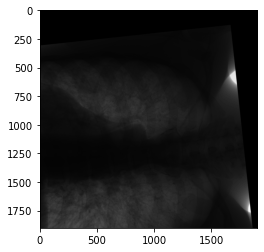

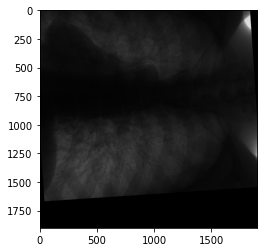

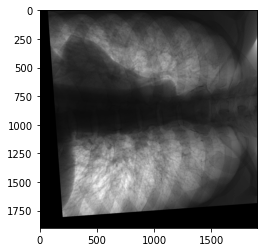

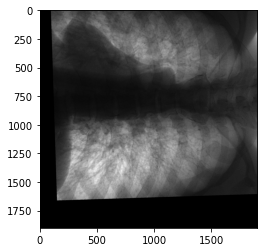

In [20]:
#Show outputs
plt.imshow(created_set[39,:,:,0], cmap= 'gray') #pic 39, channel 0
plt.show()

plt.imshow(noisycreated_set[39,:,:,0], cmap= 'gray')
plt.show()

plt.imshow(created_set[27,:,:,0], cmap= 'gray') #pic 27, channel 0
plt.show()

plt.imshow(noisycreated_set[27,:,:,0], cmap= 'gray')
plt.show()

## Splitting the dataset into training and test (80/20)

In [21]:
#splitting the dataset into training and test (80/20)
X_train, X_test = train_test_split(noisycreated_set, test_size = 0.2, random_state = 42)
y_train, y_test = train_test_split(created_set, test_size = 0.2, random_state = 42)

## Define custom SSIM Loss function

In [22]:
#define custom SSIM Loss function
def SSIMLoss(y_true, y_pred):
    """Defines a custom loss function for SSIM measurement models
    Arguments: y_true, the true data, and y_pred, calculated prediction
    Returns: SSIMLoss loss function
    """
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

## Define convolutional denoising autoencoders model

In [23]:
#network adapted from https://keras.io/examples/vision/autoencoder/

input = Input(shape = channel1.shape)

# Encoder
x = Conv2D(32, (3, 3), activation="relu", padding="same")(input)
#x = MaxPooling2D((2, 2), padding="same")(x) #maxpooling seems to add unwanted fuzziness?
x = Conv2D(16, (3, 3), activation="relu", padding="same")(x) #alternative to upscaling
# x = MaxPooling2D((2, 2), padding="same")(x)
#x = Conv2D(8, (3, 3), activation="relu", padding="same")(x) #try with and without extra layers
#x = MaxPooling2D((2, 2), padding="same")(x)

# Decoder
#x = Conv2DTranspose(8, (3, 3), strides=1, activation="relu", padding="same")(x)
x = Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = Conv2DTranspose(32, (3, 3), strides=1, activation="relu", padding="same")(x)
x = Conv2D(1, (3, 3), activation="relu", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss=SSIMLoss)
#autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1900, 1900, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, 1900, 1900, 32)    320       
                                                                 
 conv2d_1 (Conv2D)           (None, 1900, 1900, 16)    4624      
                                                                 
 conv2d_transpose (Conv2DTra  (None, 1900, 1900, 16)   2320      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 1900, 1900, 32)   4640      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 1900, 1900, 1)     289   

## Training of the convolutional autoencoder model

In [24]:
batch_size = 4
#training the model
history=autoencoder.fit(X_train, y_train,
              validation_data=(X_test, y_test),
              epochs=10,
              shuffle=True,
              batch_size=batch_size)

Epoch 1/10
8/8 [==============================] - 268s 34s/step - loss: 0.5575 - val_loss: 0.3408
Epoch 2/10
8/8 [==============================] - 265s 33s/step - loss: 0.4163 - val_loss: 0.4155
Epoch 3/10
8/8 [==============================] - 264s 33s/step - loss: 0.4085 - val_loss: 0.3357
Epoch 4/10
8/8 [==============================] - 261s 33s/step - loss: 0.3857 - val_loss: 0.3331
Epoch 5/10
8/8 [==============================] - 260s 33s/step - loss: 0.3817 - val_loss: 0.3365
Epoch 6/10
8/8 [==============================] - 259s 33s/step - loss: 0.3853 - val_loss: 0.3505
Epoch 7/10
8/8 [==============================] - 258s 33s/step - loss: 0.3810 - val_loss: 0.3401
Epoch 8/10
8/8 [==============================] - 258s 33s/step - loss: 0.3798 - val_loss: 0.3392
Epoch 9/10
8/8 [==============================] - 258s 33s/step - loss: 0.3792 - val_loss: 0.3423
Epoch 10/10
8/8 [==============================] - 258s 33s/step - loss: 0.3790 - val_loss: 0.3449


## Evalution of the training



### Ploting training and validation with training and validation loss.

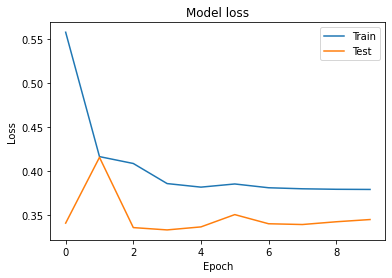

In [25]:
#plot model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#plt.ylim([0, 1])
plt.show()

### Predict Decoded Image

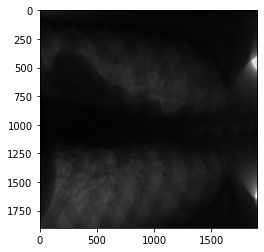

In [26]:
#predict the AE output from 'noisy' low dose test images
noisy_decoded = autoencoder.predict(samples)
plt.imshow(noisy_decoded.reshape(1900,1900), cmap= 'gray')
plt.show()

### Define a reference image

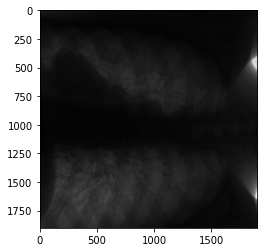

In [27]:
new_test_ref = reference[400:2300, 400:2300]
np.shape(new_test_ref)

plt.imshow(new_test_ref/np.max(new_test_ref), cmap= 'gray')
plt.show()

## Pre-processing of the of the reference image (converted to a numpy array, expanded and normalised) and visualised the evaluated the model.

### Display the reference and output (new decoded) image

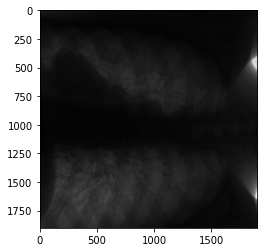

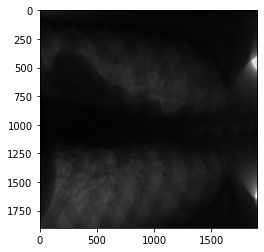

In [28]:
new_test_ref = np.array(new_test_ref)
new_test_ref = np.expand_dims(new_test_ref, 2)
new_test_ref = np.expand_dims(new_test_ref, 0)
new_test_ref.astype('float32')/np.max(new_test_ref)

new_decoded = autoencoder.predict(new_test_ref)

plt.imshow(new_test_ref.reshape(1900,1900), cmap= 'gray')
plt.show()

plt.imshow(new_decoded.reshape(1900,1900), cmap= 'gray')
plt.show()

### A defined function for the evaluation metrics to measure the performance of the model

In [29]:
def compare(imageA, imageB, title):

  psnr = peak_signal_noise_ratio(imageA, imageB) #, data_range = 255

  ssim = structural_similarity(imageA, imageB) #, multichannel=True, data_range = 255

  mse = mean_squared_error(imageA, imageB)

  nrmse = normalized_root_mse(imageA, imageB) #,  normalization='euclidean'

  # setup the figure
  fig = plt.figure(title)
  print('PSNR: %.6f, SSIM: %.6f, MSE: %.6f, NRMSE: %.6f' % (psnr, ssim, mse, nrmse))
  plt.suptitle('PSNR: %.6f, SSIM: %.6f, MSE: %.6f, NRMSE: %.6f' % (psnr, ssim, mse, nrmse))

  # show first image
  ax = fig.add_subplot(1, 2, 1)
  plt.imshow(imageA, cmap= 'gray')
  plt.axis('off')

  # show the second image
  ax = fig.add_subplot(1, 2, 2)
  plt.imshow(imageB, cmap= 'gray')
  plt.axis('off')

  # show the images
  plt.show()

  #return psnr, ssim, mse, nrmse

### A defined function to qauntify the sharpness of the image

In [30]:
def sharpness_measure(imageA, imageB, title): 
  #adapted from https://dsp.stackexchange.com/questions/35490/how-to-locally-quantify-the-sharpness-of-an-image
    """function to show the sharpness of 2 side-by-side images as gradient maps
    Arguments: 2 images, title
    Returns: Plots of the 2 images with the difference in contrast (i.e., sharpness) measured by gradient
    """
    imageA_gray = rgb2gray(imageA)
    imageB_gray = rgb2gray(imageB)
    disk_matrix = disk(5) #matrix with a disk shape
    imageA_sharpness = gradient(imageA_gray, disk_matrix)
    imageB_sharpness = gradient(imageB_gray, disk_matrix)
    #Show first image
    plt.imshow(imageA_sharpness, cmap="gray")
    plt.axis('off')
    plt.colorbar()
    plt.show()
    #show second image
    plt.imshow(imageB_sharpness, cmap="gray")
    plt.axis('off')
    plt.colorbar()
    plt.show()

In [31]:
np.max(ref)

1142

### Normalise the reference, decoded and noisy images again before for comparison.

In [32]:
#Normalising images for comparison
Normalised_reference = hd_ref/np.max(hd_ref)
Normalised_decoded = noisy_decoded[0].reshape(1900, 1900)/np.max(noisy_decoded[0])
Normalised_noisy_original = ref/np.max(ref)

### Compare reference (clean) image with the denoised image

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  """


PSNR: 39.700601, SSIM: 0.993062, MSE: 0.000107, NRMSE: 0.084982


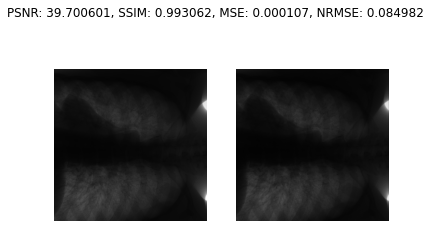

In [33]:
#Compare images clean reference with de-noised
compare(Normalised_reference, Normalised_decoded,"boo")
#for similarity want mse to be 0, ssim to be 1

### Compare reference (clean) image with the noisy image

PSNR: 36.516937, SSIM: 0.978195, MSE: 0.000223, NRMSE: 0.122606


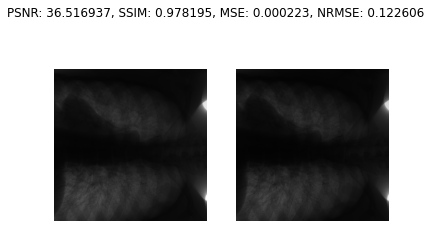

In [34]:
#Compare images clean reference with noisy original
compare(Normalised_reference, Normalised_noisy_original, "boo")

### Save the decoded output image as pdf

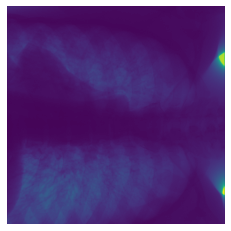

In [35]:
#save the decoded output image as as pdf
decodedimg = plt.figure()
plt.axis('off')
plt.imshow(Normalised_decoded)
plt.show()
decodedimg.savefig('decoded_dicom.pdf')

### Comparison the sharpness of the image

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning

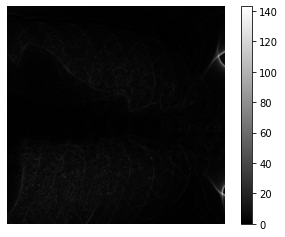

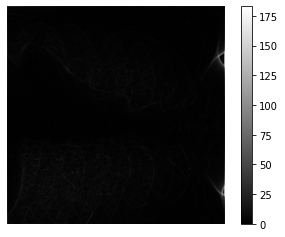

In [36]:
#image comparison for sharpness
sharpness_measure(Normalised_reference,Normalised_decoded, 'boo')

## Define a median filter function, applied the fuction to the noisy image and display the output (filltered) image

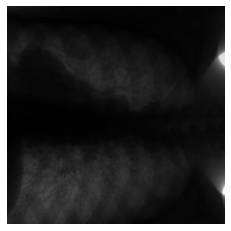

In [37]:
median_filter = ndimage.median_filter(ref, size= 5) 

# show first image
#ax = fig.add_subplot(1, 2, 1)
plt.imshow(median_filter, cmap= 'gray')
plt.axis('off')

# show the images
plt.show()

### Normalised the (bilateral) filtered image and compare the reference (clean) image with the (bilateral) filtered image

PSNR: 40.205229, SSIM: 0.990901, MSE: 0.000095, NRMSE: 0.080185


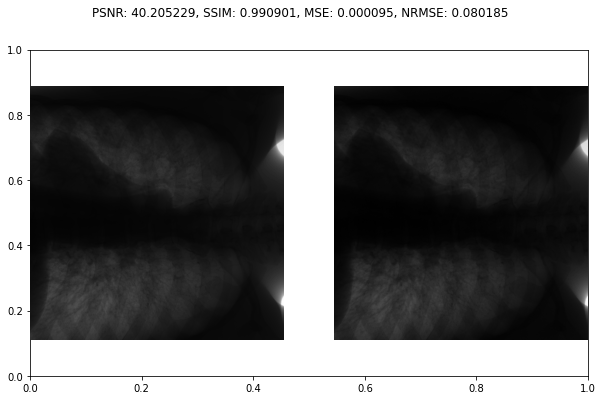

In [38]:
Normalised_median_filter = median_filter/np.max(median_filter)

#compare images clean reference image with filtered image by median_filter
plt.subplots(figsize=(10, 6))
compare (Normalised_reference, Normalised_median_filter,'')
#ideally want mse to be close to 0, ssim to be close to 1 

## Normalise the noisy image again, define a bilateal filter function, applied the fuction to the noisy image and display the output (filltered) image

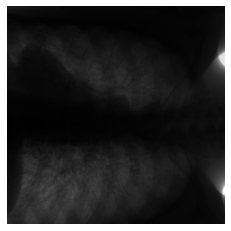

In [39]:
refb = ref.astype('float32')/np.max(ref)

bilateral_filter = cv2.bilateralFilter(refb,  5, 50, 50)

# show the second image
#ax = fig.add_subplot(1, 2, 2)
plt.imshow(bilateral_filter, cmap= 'gray')
plt.axis('off')

# show the images
plt.show()

### Compare reference (clean) image with the (bilateral) filtered image

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  """


PSNR: 41.131155, SSIM: 0.991848, MSE: 0.000077, NRMSE: 0.072077


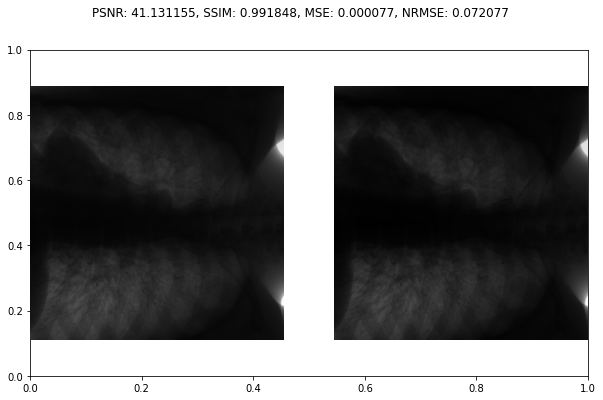

In [40]:
Normalised_bilateral_filter = bilateral_filter/np.max(bilateral_filter)

#compare images clean reference with filtered image by bilateral_filter
plt.subplots(figsize=(10, 6))
compare (Normalised_reference, Normalised_bilateral_filter,'')
#ideally want mse to be close to 0, ssim to be close to 1 

# Graph plots

## Graph plots to compare the efectivenes of the models with evlaution metrics

### CDAE with for DICOM images with the grid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


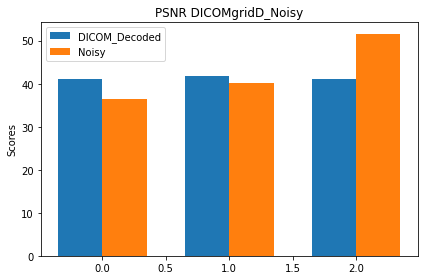

In [41]:
labels = [0.25, 1.4, 1.25]

PSNR_Dgrid = [41.083800, 41.896137, 41.082778]

PSNR_Noisy_Dgrid = [36.516937, 40.148407, 51.670146]


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, PSNR_Dgrid, width, label='DICOM_Decoded')
bar2 = ax.bar(x + width/2, PSNR_Noisy_Dgrid, width, label='Noisy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('PSNR DICOMgridD_Noisy')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


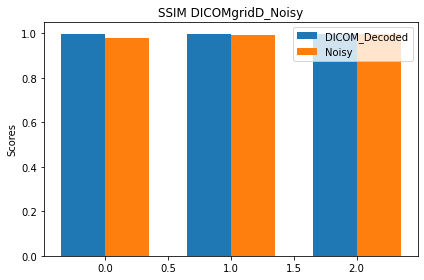

In [42]:
labels = [0.25, 1.4, 1.25]

SSIM_Dgrid = [0.994574, 0.996261, 0.998444]

SSIM_Noisy_Dgrid = [0.978195, 0.990310, 0.998756]


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, SSIM_Dgrid, width, label='DICOM_Decoded')
bar2 = ax.bar(x + width/2, SSIM_Noisy_Dgrid, width, label='Noisy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('SSIM DICOMgridD_Noisy')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

### Filters for DICOM images with no grids

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


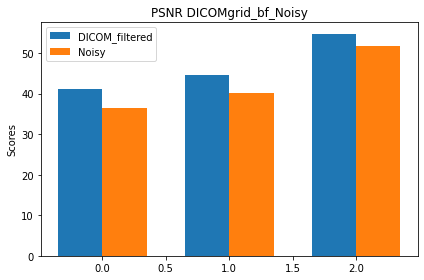

In [43]:
labels = [0.25, 1.4, 1.25]

PSNR_grid_bf = [41.131155, 44.535142, 54.819642]

PSNR_Noisy_grid_bf = [36.516937, 40.148407, 51.670146]


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, PSNR_grid_bf, width, label='DICOM_filtered')
bar2 = ax.bar(x + width/2, PSNR_Noisy_grid_bf, width, label='Noisy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('PSNR DICOMgrid_bf_Noisy')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


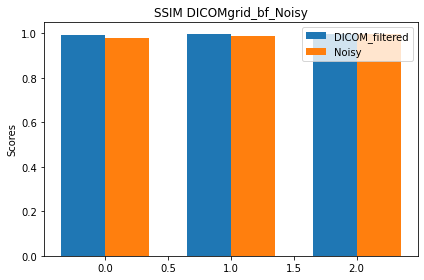

In [44]:
labels = [0.25, 1.4, 1.25]

SSIM_Dgrid_bf = [0.991848, 0.996352, 0.999344]

SSIM_Noisy_Dgrid_bf = [0.978195, 0.990310, 0.998756]


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, SSIM_Dgrid_bf, width, label='DICOM_filtered')
bar2 = ax.bar(x + width/2, SSIM_Noisy_Dgrid_bf, width, label='Noisy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('SSIM DICOMgrid_bf_Noisy')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

## *Graph plots of evaluation metrics for denoised DICOM images at different levels of radiation with CDAEs plus anti-scatter grid*


In [45]:
# initialize data of lists.
data = {
    'ClinDose_GridDE': [0.25, 0.40, 1.25],
    'PSNR_GridDE': [41.083800, 41.896137, 41.082778],
    'SSIM_GridDE': [0.994574, 0.996261, 0.998444],
    'MSE_GridDE' : [0.000078, 0.000065, 0.000078],
    'NRMSE_GridDE': [0.072471, 0.065960, 0.072347]
    }


# Create DataFrame
df_decodedGrid = pd.DataFrame(data)

print(df_decodedGrid)

   ClinDose_GridDE  PSNR_GridDE  SSIM_GridDE  MSE_GridDE  NRMSE_GridDE
0             0.25    41.083800     0.994574    0.000078      0.072471
1             0.40    41.896137     0.996261    0.000065      0.065960
2             1.25    41.082778     0.998444    0.000078      0.072347


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d22c8ba10>,
      dtype=object)

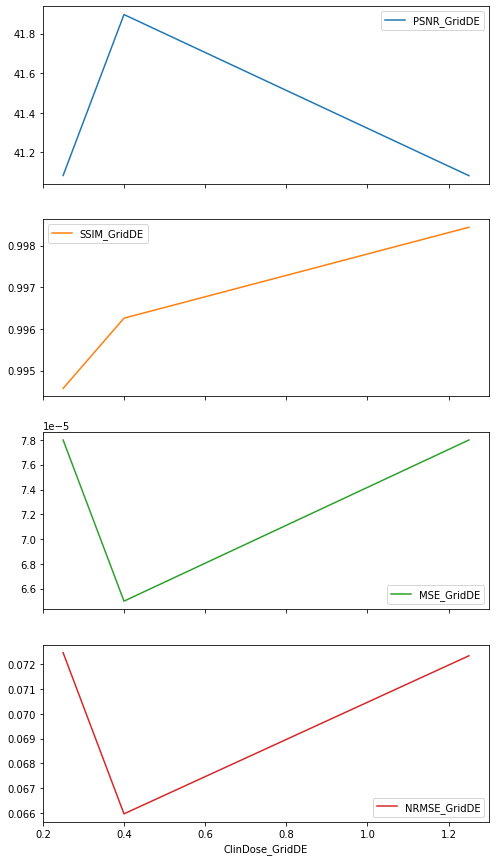

In [46]:
df_decodedGrid.plot.line(x = "ClinDose_GridDE", subplots = True, figsize=(8, 15))

Text(0.5, 1.0, 'Noise-PSNR_GridDE for Denoised_DICOM AEs')

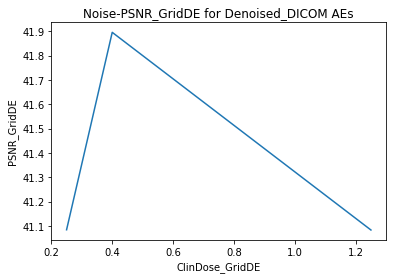

In [47]:
sns.lineplot(data= df_decodedGrid, x = "ClinDose_GridDE", y = "PSNR_GridDE")
plt.title("Noise-PSNR_GridDE for Denoised_DICOM AEs")

Text(0.5, 1.0, 'Noise-SSIM_GridDE for Denoised_DICOM AEs')

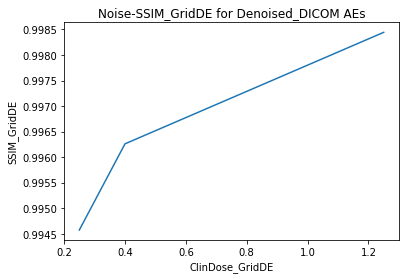

In [48]:
sns.lineplot(data= df_decodedGrid, x = "ClinDose_GridDE", y = "SSIM_GridDE")
plt.title("Noise-SSIM_GridDE for Denoised_DICOM AEs")

Text(0.5, 1.0, 'Noise-MSE_GridDE for Denoised_DICOM AEs')

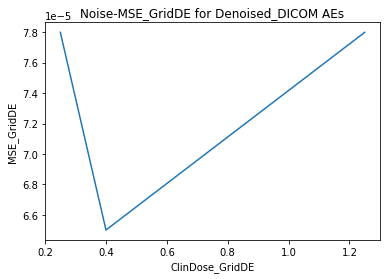

In [49]:
sns.lineplot(data= df_decodedGrid, x = "ClinDose_GridDE", y = "MSE_GridDE")
plt.title("Noise-MSE_GridDE for Denoised_DICOM AEs")

Text(0.5, 1.0, 'Noise-NRMSE_GridDE for Denoised_DICOM AEs')

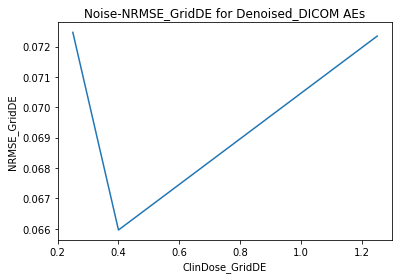

In [50]:
sns.lineplot(data= df_decodedGrid, x = "ClinDose_GridDE", y = "NRMSE_GridDE")
plt.title("Noise-NRMSE_GridDE for Denoised_DICOM AEs")

## *Graph plots of evaluation metrics for filtered DICOM images at at different levels of radiation with Median filters plus the anti-scatter grid*


In [51]:
# initialize data of lists.
data = {
    'ClinDose_GridMF': [0.25, 0.40, 1.25],
    'PSNR_GridMF': [40.205229, 43.738960, 54.765020],
    'SSIM_GridMF': [0.990901, 0.996022, 0.999317],
    'MSE_GridMF' : [0.000095, 0.000042, 0.000003],
    'NRMSE_GridMF': [0.080185, 0.053351, 0.014973]
    }


# Create DataFrame
df_MedianGrid = pd.DataFrame(data)

print(df_MedianGrid)

   ClinDose_GridMF  PSNR_GridMF  SSIM_GridMF  MSE_GridMF  NRMSE_GridMF
0             0.25    40.205229     0.990901    0.000095      0.080185
1             0.40    43.738960     0.996022    0.000042      0.053351
2             1.25    54.765020     0.999317    0.000003      0.014973


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d374650d0>,
      dtype=object)

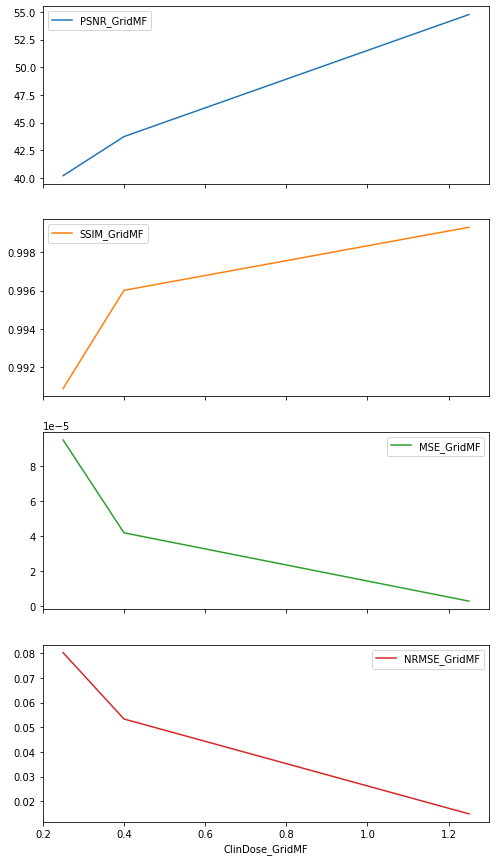

In [52]:
df_MedianGrid.plot.line(x = "ClinDose_GridMF", subplots = True, figsize=(8, 15))

Text(0.5, 1.0, 'Noise-PSNR_GridMF for MF_DICOM')

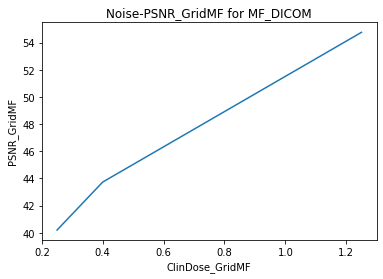

In [53]:
sns.lineplot(data= df_MedianGrid, x = "ClinDose_GridMF", y = "PSNR_GridMF")
plt.title("Noise-PSNR_GridMF for MF_DICOM")

Text(0.5, 1.0, 'Noise-SSIM_GridMF for MF_DICOM')

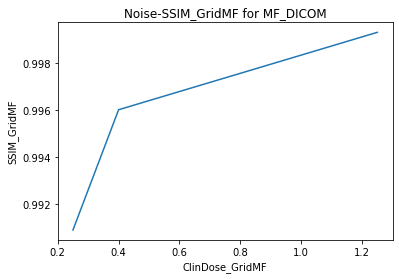

In [54]:
sns.lineplot(data= df_MedianGrid, x = "ClinDose_GridMF", y = "SSIM_GridMF")
plt.title("Noise-SSIM_GridMF for MF_DICOM")

Text(0.5, 1.0, 'Noise-MSE_GridMF for MF_DICOM')

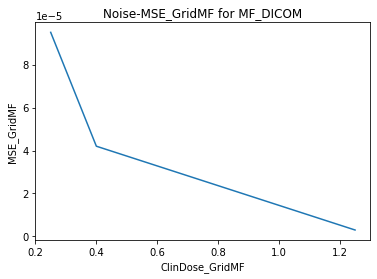

In [55]:
sns.lineplot(data= df_MedianGrid, x = "ClinDose_GridMF", y = "MSE_GridMF")
plt.title("Noise-MSE_GridMF for MF_DICOM")

Text(0.5, 1.0, 'Noise-NRMSE_GridMF for MF_DICOM')

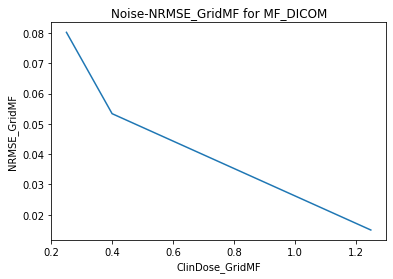

In [56]:
sns.lineplot(data= df_MedianGrid, x = "ClinDose_GridMF", y = "NRMSE_GridMF")
plt.title("Noise-NRMSE_GridMF for MF_DICOM")

## *Graph plots of evaluation metrics for filtered DICOM images at different levels of radiation with bilateral filters plus the anti-scatter grid*

In [57]:
# initialize data of lists.
data = {
    'ClinDose_GridBF': [0.25, 0.40, 1.25],
    'PSNR_GridBF': [41.131155, 44.535142, 54.819642],
    'SSIM_GridBF': [0.991848, 0.996352, 0.999344],
    'MSE_GridBF' : [0.000077, 0.000035, 0.000003],
    'NRMSE_GridBF': [0.072077, 0.048678, 0.014879]
    }


# Create DataFrame
df_BilateralGrid = pd.DataFrame(data)

print(df_BilateralGrid)

   ClinDose_GridBF  PSNR_GridBF  SSIM_GridBF  MSE_GridBF  NRMSE_GridBF
0             0.25    41.131155     0.991848    0.000077      0.072077
1             0.40    44.535142     0.996352    0.000035      0.048678
2             1.25    54.819642     0.999344    0.000003      0.014879


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d25b60610>,
      dtype=object)

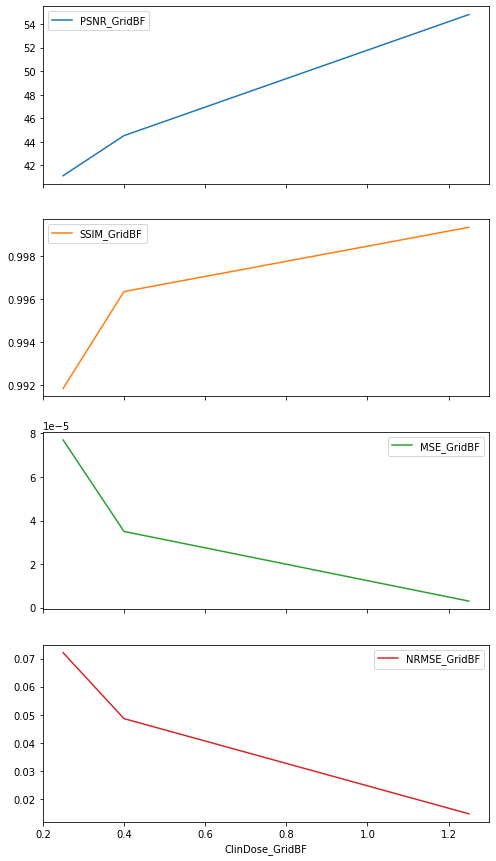

In [58]:
df_BilateralGrid.plot.line(x = "ClinDose_GridBF", subplots = True, figsize=(8, 15))

Text(0.5, 1.0, 'Noise-PSNR_GridBF for BF_DICOM')

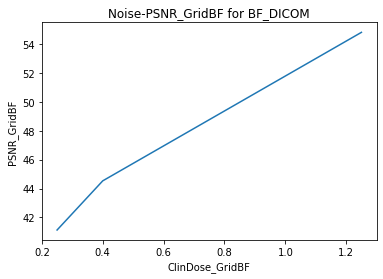

In [59]:
sns.lineplot(data= df_BilateralGrid, x = "ClinDose_GridBF", y = "PSNR_GridBF")
plt.title("Noise-PSNR_GridBF for BF_DICOM")

Text(0.5, 1.0, 'Noise-SSIM_GridBF for BF_DICOM')

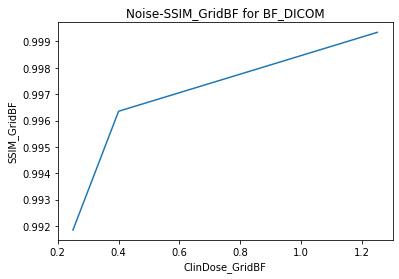

In [60]:
sns.lineplot(data= df_BilateralGrid, x = "ClinDose_GridBF", y = "SSIM_GridBF")
plt.title("Noise-SSIM_GridBF for BF_DICOM")

Text(0.5, 1.0, 'Noise-MSE_GridBF for BF_DICOM')

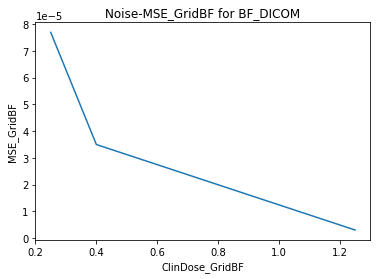

In [61]:
sns.lineplot(data= df_BilateralGrid, x = "ClinDose_GridBF", y = "MSE_GridBF")
plt.title("Noise-MSE_GridBF for BF_DICOM")

Text(0.5, 1.0, 'Noise-NRMSE_GridBF for BF_DICOM')

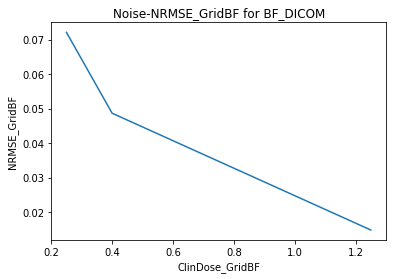

In [62]:
sns.lineplot(data= df_BilateralGrid, x = "ClinDose_GridBF", y = "NRMSE_GridBF")
plt.title("Noise-NRMSE_GridBF for BF_DICOM")